In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
shutil.move('/content/drive/My Drive/input', '.')


'./input'

# Importing Required Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter
import cv2
from concurrent import futures
import threading
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import datetime
from prettytable import PrettyTable

# Reading the Dataset

In [ ]:
#getting the total number of images in the training set
print(os.listdir("input/train/train"))


base_dir = os.path.join('input/train/train')
type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

len(type1_files),len(type2_files),len(type3_files)

['Type_2', 'Type_3', 'Type_1']


(1337, 781, 450)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_data(img_path, n_augmented_images):
    try:
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=os.path.dirname(img_path), save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= n_augmented_images:
                break
    except OSError as e:
        print(f"OSError occurred for file: {img_path}, Error: {e}")

for img_path in type1_files + type2_files + type3_files:
    augment_data(img_path, n_augmented_images=5)

type1_files = glob.glob(type1_dir + '/*.jpg')
type2_files = glob.glob(type2_dir + '/*.jpg')
type3_files = glob.glob(type3_dir + '/*.jpg')

OSError occurred for file: input/train/train/Type_1/1339.jpg, Error: image file is truncated (53 bytes not processed)


In [ ]:
#Building a dataframe mapping images and Cancer type
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,input/train/train/Type_3/324.jpg,Type_3
1,input/train/train/Type_1/aug_0_2617.jpg,Type_1
2,input/train/train/Type_1/aug_0_1388.jpg,Type_1
3,input/train/train/Type_1/aug_0_4245.jpg,Type_1
4,input/train/train/Type_1/aug_0_4184.jpg,Type_1


# Split Dataset

In [ ]:
from sklearn.model_selection import StratifiedKFold
from collections import Counter

def cross_validation_split(files, labels, n_splits=8):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_splits = []

    for train_index, test_index in skf.split(files, labels):
        train_files, test_files = files[train_index], files[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]

        train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels,
                                                                            test_size=0.1, random_state=42)

        le = LabelEncoder()
        le.fit(train_labels)
        train_labels_enc = le.transform(train_labels)
        val_labels_enc = le.transform(val_labels)
        test_labels_enc = le.transform(test_labels)

        NUM_CLASSES = len(le.classes_)
        train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
        val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=NUM_CLASSES)
        test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=NUM_CLASSES)

        cv_splits.append({
            'train_files': train_files,
            'train_labels': train_labels,
            'train_labels_1hotenc': train_labels_1hotenc,  # Add one-hot encoded train labels
            'val_files': val_files,
            'val_labels': val_labels,
            'val_labels_1hotenc': val_labels_1hotenc,      # Add one-hot encoded validation labels
            'test_files': test_files,
            'test_labels': test_labels,
            'test_labels_1hotenc': test_labels_1hotenc     # Add one-hot encoded test labels
        })

    return cv_splits

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values,
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

cv_splits = cross_validation_split(files_df['filename'].values, files_df['label'].values)

for i, split in enumerate(cv_splits):
    print(f"Split {i+1}:")
    print('Train:', Counter(split['train_labels']), '\nVal:', Counter(split['val_labels']), '\nTest:', Counter(split['test_labels']))


Split 1:
Train: Counter({'Type_1': 1057, 'Type_2': 609, 'Type_3': 356}) 
Val: Counter({'Type_1': 113, 'Type_2': 75, 'Type_3': 37}) 
Test: Counter({'Type_1': 167, 'Type_2': 97, 'Type_3': 57})
Split 2:
Train: Counter({'Type_1': 1072, 'Type_2': 597, 'Type_3': 353}) 
Val: Counter({'Type_1': 98, 'Type_2': 87, 'Type_3': 40}) 
Test: Counter({'Type_1': 167, 'Type_2': 97, 'Type_3': 57})
Split 3:
Train: Counter({'Type_1': 1042, 'Type_2': 613, 'Type_3': 367}) 
Val: Counter({'Type_1': 127, 'Type_2': 71, 'Type_3': 27}) 
Test: Counter({'Type_1': 168, 'Type_2': 97, 'Type_3': 56})
Split 4:
Train: Counter({'Type_1': 1055, 'Type_2': 611, 'Type_3': 356}) 
Val: Counter({'Type_1': 115, 'Type_2': 72, 'Type_3': 38}) 
Test: Counter({'Type_1': 167, 'Type_2': 98, 'Type_3': 56})
Split 5:
Train: Counter({'Type_1': 1054, 'Type_2': 612, 'Type_3': 356}) 
Val: Counter({'Type_1': 116, 'Type_2': 71, 'Type_3': 38}) 
Test: Counter({'Type_1': 167, 'Type_2': 98, 'Type_3': 56})
Split 6:
Train: Counter({'Type_1': 1062, 'Type

## Summary of the dataset dimensions


In [ ]:
import cv2
from concurrent import futures

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name, idx))
    return cv2.imread(img).shape

def compute_image_dimensions_parallel(image_files):
    ex = futures.ThreadPoolExecutor(max_workers=None)
    data_inp = [(idx, img, len(image_files)) for idx, img in enumerate(image_files)]
    print('Starting Img shape computation:')
    img_dims_map = ex.map(get_img_shape_parallel,
                          [record[0] for record in data_inp],
                          [record[1] for record in data_inp],
                          [record[2] for record in data_inp])
    img_dims = list(img_dims_map)
    print('Min Dimensions:', np.min(img_dims, axis=0))
    print('Avg Dimensions:', np.mean(img_dims, axis=0))
    print('Median Dimensions:', np.median(img_dims, axis=0))
    print('Max Dimensions:', np.max(img_dims, axis=0))

compute_image_dimensions_parallel(train_files)

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0


KeyboardInterrupt: 

In [ ]:
IMG_DIMS = (224, 224)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name, idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

def load_images_parallel(image_files):
    ex = futures.ThreadPoolExecutor(max_workers=None)
    data_inp = [(idx, img, len(image_files)) for idx, img in enumerate(image_files)]
    print(f'Loading {len(image_files)} Images:')
    data_map = ex.map(get_img_data_parallel,
                      [record[0] for record in data_inp],
                      [record[1] for record in data_inp],
                      [record[2] for record in data_inp])
    data = np.array(list(data_map))
    return data

train_data = load_images_parallel(train_files)
val_data = load_images_parallel(val_files)
test_data = load_images_parallel(test_files)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Loading 1617 Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_4: working on img num: 1616
Loading 180 Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_4: working on img num: 179
Loading 771 Images:
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_1: working on img num: 770
Train data shape: (1617, 224, 224, 3)
Validation data shape: (180, 224, 224, 3)
Test data shape: (771, 224, 224, 3)


# Viewing some sample images


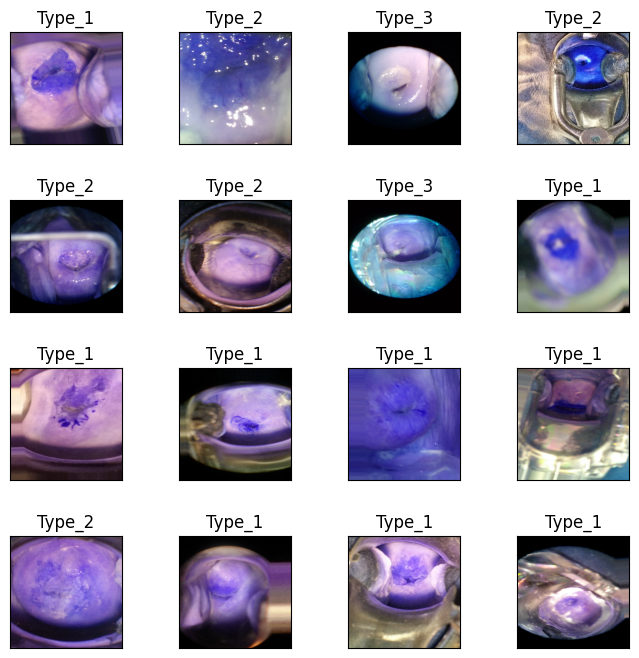

In [ ]:
plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

BATCH_SIZE = 64
NUM_CLASSES = 3
EPOCHS = 20
INPUT_SHAPE = (224, 224, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_1' 'Type_1' 'Type_1' 'Type_3' 'Type_1' 'Type_1'] [0 0 0 2 0 0]
['Type_1' 'Type_1' 'Type_1' 'Type_3' 'Type_1' 'Type_1'] [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
#scaling the test set and one-hot encoding the test labels
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

le = LabelEncoder()
le.fit(test_labels)
test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = to_categorical(test_labels_enc, num_classes=3)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1' 'Type_1'] [2 0 0 1 0 0]
['Type_3' 'Type_1' 'Type_1' 'Type_2' 'Type_1' 'Type_1'] [[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## **VGG19**

In [ ]:
vgg19_total_train_time = 0
vgg19_history_list = []

for i, split in enumerate(cv_splits):
    print(f"Fold {i+1}:")
    train_files_fold = split['train_files']
    train_labels_fold = split['train_labels_1hotenc']
    val_files_fold = split['val_files']
    val_labels_fold = split['val_labels_1hotenc']

    vgg19Net = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    vgg19Net.trainable = False

    for layer in vgg19Net.layers:
        layer.trainable = False

    base_vgg19 = vgg19Net
    base_out_vgg19 = base_vgg19.output
    pool_out_vgg19 = tf.keras.layers.Flatten()(base_out_vgg19)
    hidden1_vgg19 = tf.keras.layers.Dense(512, activation='relu')(pool_out_vgg19)
    drop1_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden1_vgg19)
    hidden2_vgg19 = tf.keras.layers.Dense(512, activation='relu')(drop1_vgg19)
    drop2_vgg19 = tf.keras.layers.Dropout(rate=0.3)(hidden2_vgg19)
    out_vgg19 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(drop2_vgg19)

    vgg19_model = tf.keras.Model(inputs=base_vgg19.input, outputs=out_vgg19)
    vgg19_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    print("Training VGG19 model for this fold...")
    vgg19_start = time.time()
    vgg19_history = vgg19_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                                    verbose=1)
    vgg19_stop = time.time()
    fold_train_time = vgg19_stop - vgg19_start
    vgg19_total_train_time += fold_train_time
    print(f"Training time for Fold {i+1}: {fold_train_time} seconds")

    vgg19_history_list.append(vgg19_history)

avg_vgg19_train_time = vgg19_total_train_time / len(cv_splits)
print(f"Average training time across all folds: {avg_vgg19_train_time} seconds")


Fold 1:
Training VGG19 model for this fold...


## VGG19 Summary

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from prettytable import PrettyTable

vgg19_model_accuracy = []
vgg19_model_test_accuracy = []
vgg19_model_test_loss = []
vgg19_train_times = []

fpr_list = []
tpr_list = []
roc_auc_list = []

for i, history in enumerate(vgg19_history_list):
    fold_start_time = time.time()

    vgg19_model_accuracy.append(history.history['accuracy'][-1] * 100)

    test_loss, test_accuracy = vgg19_model.evaluate(test_imgs_scaled, test_labels_1hotenc, verbose=0)
    vgg19_model_test_accuracy.append(test_accuracy * 100)
    vgg19_model_test_loss.append(test_loss * 100)

    test_pred = vgg19_model.predict(test_imgs_scaled)
    fpr_fold = dict()
    tpr_fold = dict()
    roc_auc_fold = dict()
    for j in range(NUM_CLASSES):
        fpr_fold[j], tpr_fold[j], _ = roc_curve(test_labels_1hotenc[:, j], test_pred[:, j])
        roc_auc_fold[j] = auc(fpr_fold[j], tpr_fold[j])
    fpr_list.append(fpr_fold)
    tpr_list.append(tpr_fold)
    roc_auc_list.append(roc_auc_fold)

    fold_end_time = time.time()
    fold_train_time = fold_end_time - fold_start_time
    vgg19_train_times.append(fold_train_time)

avg_vgg19_train_time = sum(vgg19_train_times) / len(vgg19_train_times)

vgg19_summary = PrettyTable(["VGG19", ""])
vgg19_summary.add_row(["Average Model Accuracy (%)", "{:.2f}".format(np.mean(vgg19_model_accuracy))])
vgg19_summary.add_row(["Average Test Accuracy (%)", "{:.2f}".format(np.mean(vgg19_model_test_accuracy))])
vgg19_summary.add_row(["Average Test Loss (%)", "{:.2f}".format(np.mean(vgg19_model_test_loss))])
vgg19_summary.add_row(["Average Training Time (seconds)", "{:.2f}".format(avg_vgg19_train_time)])
print(vgg19_summary)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, history in enumerate(vgg19_history_list):
    plt.plot(history.history['accuracy'], label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, history in enumerate(vgg19_history_list):
    plt.plot(history.history['loss'], label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot([0, 1], [0, 1], 'k--')
    for j in range(len(fpr_list)):
        plt.plot(fpr_list[j][i], tpr_list[j][i], label=f'Fold {j+1} (AUC = {roc_auc_list[j][i]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend()
    plt.show()


# Xception

In [ ]:
#using Xception trained model
Xception = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                        input_shape=INPUT_SHAPE)
Xception.trainable = False
# Freeze the layers
for layer in Xception.layers:
    layer.trainable = False

base_Xception = Xception
base_out_Xception = base_Xception.output
pool_out_Xception = tf.keras.layers.Flatten()(base_out_Xception)
hidden1_Xception = tf.keras.layers.Dense(512, activation='relu')(pool_out_Xception)
drop1_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden1_Xception)
hidden2_Xception = tf.keras.layers.Dense(512, activation='relu')(drop1_Xception)
drop2_Xception = tf.keras.layers.Dropout(rate=0.3)(hidden2_Xception)
out_Xception = tf.keras.layers.Dense(3, activation='softmax')(drop2_Xception)

Xception_model = tf.keras.Model(inputs=base_Xception.input, outputs=out_Xception)
Xception_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
Xception.summary()

83683744/83683744 [==============================] - 6s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [ ]:
Xception_start = time.time()
Xception_history = Xception_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
Xception_stop = time.time()


Epoch 1/20
26/26 [==============================] - 34s 799ms/step - loss: 2.2242 - accuracy: 0.4317 - val_loss: 1.1409 - val_accuracy: 0.5444
Epoch 2/20
26/26 [==============================] - 8s 306ms/step - loss: 0.9512 - accuracy: 0.5659 - val_loss: 1.3941 - val_accuracy: 0.5500
Epoch 3/20
26/26 [==============================] - 7s 287ms/step - loss: 0.8731 - accuracy: 0.5968 - val_loss: 0.8680 - val_accuracy: 0.6056
Epoch 4/20
26/26 [==============================] - 8s 315ms/step - loss: 0.7288 - accuracy: 0.6729 - val_loss: 0.8017 - val_accuracy: 0.6278
Epoch 5/20
26/26 [==============================] - 8s 297ms/step - loss: 0.6628 - accuracy: 0.7069 - val_loss: 0.8726 - val_accuracy: 0.6389
Epoch 6/20
26/26 [==============================] - 8s 328ms/step - loss: 0.5815 - accuracy: 0.7471 - val_loss: 0.7232 - val_accuracy: 0.6444
Epoch 7/20
26/26 [==============================] - 8s 310ms/step - loss: 0.4843 - accuracy: 0.7953 - val_loss: 0.8732 - val_accuracy: 0.6278
Epoch

## Xception Summary

25/25 [==============================] - 8s 186ms/step - loss: 1.1307 - accuracy: 0.6848
+--------------------------------+--------+
|            Xception            |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 98.02  |
|       Test Accuracy in %       | 68.48  |
|         Test Loss in %         | 113.07 |
| Time Taken To Train in Seconds | 209.08 |
+--------------------------------+--------+


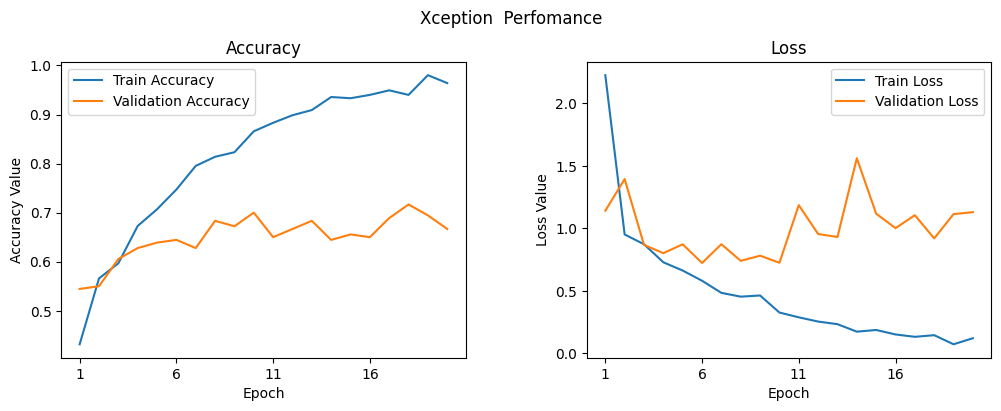

In [ ]:
Xception_trainTime=Xception_stop-Xception_start
Xception_model_accuracy = Xception_history.history['accuracy'][np.argmin(Xception_history.history['loss'])]
Xception_model_score=Xception_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
Xception_Summary = PrettyTable(["Xception"," "])
Xception_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(Xception_model_accuracy*100)])
Xception_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(Xception_model_score[1]*100)])
Xception_Summary.add_row(["Test Loss in %", "{:.2f}".format(Xception_model_score[0]*100)])
Xception_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(Xception_trainTime)])
print(Xception_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Xception  Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(Xception_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, Xception_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, Xception_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, Xception_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, Xception_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# ResNet

In [ ]:
#using ResNet trained model
ResNet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',
                                        input_shape=INPUT_SHAPE)
ResNet.trainable = False
# Freeze the layers
for layer in ResNet.layers:
    layer.trainable = False

base_ResNet = ResNet
base_out_ResNet = base_ResNet.output
pool_out_ResNet = tf.keras.layers.Flatten()(base_out_ResNet)
hidden1_ResNet = tf.keras.layers.Dense(512, activation='relu')(pool_out_ResNet)
drop1_ResNet = tf.keras.layers.Dropout(rate=0.3)(hidden1_ResNet)
hidden2_ResNet = tf.keras.layers.Dense(512, activation='relu')(drop1_ResNet)
drop2_ResNet = tf.keras.layers.Dropout(rate=0.3)(hidden2_ResNet)
out_ResNet = tf.keras.layers.Dense(3, activation='softmax')(drop2_ResNet)

ResNet_model = tf.keras.Model(inputs=base_ResNet.input, outputs=out_ResNet)
ResNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
ResNet.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
ResNet_start = time.time()
ResNet_history = ResNet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
ResNet_stop = time.time()

Epoch 1/20
26/26 [==============================] - 21s 526ms/step - loss: 1.8300 - accuracy: 0.3946 - val_loss: 1.0778 - val_accuracy: 0.5222
Epoch 2/20
26/26 [==============================] - 6s 237ms/step - loss: 1.0864 - accuracy: 0.4589 - val_loss: 1.0934 - val_accuracy: 0.2889
Epoch 3/20
26/26 [==============================] - 6s 241ms/step - loss: 1.0541 - accuracy: 0.4601 - val_loss: 1.0257 - val_accuracy: 0.5111
Epoch 4/20
26/26 [==============================] - 6s 230ms/step - loss: 1.0383 - accuracy: 0.4941 - val_loss: 1.0495 - val_accuracy: 0.5111
Epoch 5/20
26/26 [==============================] - 6s 234ms/step - loss: 1.0450 - accuracy: 0.5065 - val_loss: 1.0432 - val_accuracy: 0.5111
Epoch 6/20
26/26 [==============================] - 6s 230ms/step - loss: 1.0370 - accuracy: 0.4966 - val_loss: 1.0162 - val_accuracy: 0.5111
Epoch 7/20
26/26 [==============================] - 6s 228ms/step - loss: 1.0294 - accuracy: 0.5077 - val_loss: 1.0168 - val_accuracy: 0.5111
Epoch

## ResNet Summary

25/25 [==============================] - 5s 133ms/step - loss: 0.9833 - accuracy: 0.5525
+--------------------------------+--------+
|             ResNet             |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 50.65  |
|       Test Accuracy in %       | 55.25  |
|         Test Loss in %         | 98.33  |
| Time Taken To Train in Seconds | 148.25 |
+--------------------------------+--------+


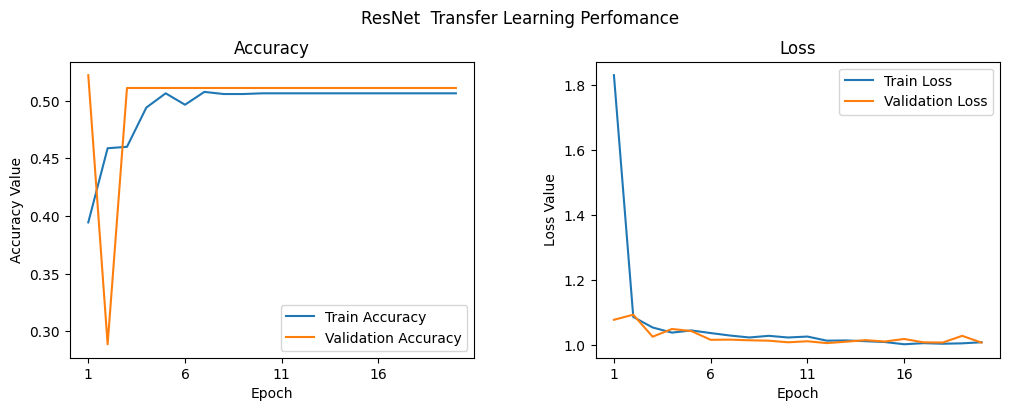

In [ ]:
ResNet_trainTime=ResNet_stop-ResNet_start
ResNet_model_accuracy = ResNet_history.history['accuracy'][np.argmin(ResNet_history.history['loss'])]
ResNet_model_score=ResNet_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
ResNet_Summary = PrettyTable(["ResNet"," "])
ResNet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(ResNet_model_accuracy*100)])
ResNet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(ResNet_model_score[1]*100)])
ResNet_Summary.add_row(["Test Loss in %", "{:.2f}".format(ResNet_model_score[0]*100)])
ResNet_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(ResNet_trainTime)])
print(ResNet_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet  Transfer Learning Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(ResNet_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, ResNet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, ResNet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, ResNet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, ResNet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# InceptionV3

In [ ]:
#using InceptionV3 trained model
InceptionV3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',
                                        input_shape=INPUT_SHAPE)
InceptionV3.trainable = False
# Freeze the layers
for layer in InceptionV3.layers:
    layer.trainable = False

base_InceptionV3 = InceptionV3
base_out_InceptionV3 = base_InceptionV3.output
pool_out_InceptionV3 = tf.keras.layers.Flatten()(base_out_InceptionV3)
hidden1_InceptionV3 = tf.keras.layers.Dense(512, activation='relu')(pool_out_InceptionV3)
drop1_InceptionV3 = tf.keras.layers.Dropout(rate=0.3)(hidden1_InceptionV3)
hidden2_InceptionV3 = tf.keras.layers.Dense(512, activation='relu')(drop1_InceptionV3)
drop2_InceptionV3 = tf.keras.layers.Dropout(rate=0.3)(hidden2_InceptionV3)
out_InceptionV3 = tf.keras.layers.Dense(3, activation='softmax')(drop2_InceptionV3)

InceptionV3_model = tf.keras.Model(inputs=base_InceptionV3.input, outputs=out_InceptionV3)
InceptionV3_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
InceptionV3.summary()

87910968/87910968 [==============================] - 6s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 111, 111, 32)         96        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activatio

In [ ]:
InceptionV3_start = time.time()
InceptionV3_history = InceptionV3_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
InceptionV3_stop = time.time()

Epoch 1/20
26/26 [==============================] - 24s 497ms/step - loss: 2.7204 - accuracy: 0.4292 - val_loss: 1.0641 - val_accuracy: 0.4167
Epoch 2/20
26/26 [==============================] - 4s 171ms/step - loss: 1.1208 - accuracy: 0.4898 - val_loss: 0.9793 - val_accuracy: 0.5389
Epoch 3/20
26/26 [==============================] - 4s 160ms/step - loss: 0.9759 - accuracy: 0.5541 - val_loss: 0.8786 - val_accuracy: 0.5333
Epoch 4/20
26/26 [==============================] - 4s 174ms/step - loss: 0.9167 - accuracy: 0.5832 - val_loss: 0.8534 - val_accuracy: 0.6111
Epoch 5/20
26/26 [==============================] - 4s 159ms/step - loss: 0.8074 - accuracy: 0.6252 - val_loss: 0.7949 - val_accuracy: 0.6444
Epoch 6/20
26/26 [==============================] - 4s 166ms/step - loss: 0.7558 - accuracy: 0.6815 - val_loss: 0.7646 - val_accuracy: 0.6667
Epoch 7/20
26/26 [==============================] - 4s 169ms/step - loss: 0.7130 - accuracy: 0.6895 - val_loss: 0.7684 - val_accuracy: 0.6889
Epoch

## InceptionV3 Summary

25/25 [==============================] - 6s 132ms/step - loss: 1.1479 - accuracy: 0.6654
+--------------------------------+--------+
|          InceptionV3           |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 98.27  |
|       Test Accuracy in %       | 66.54  |
|         Test Loss in %         | 114.79 |
| Time Taken To Train in Seconds | 151.49 |
+--------------------------------+--------+


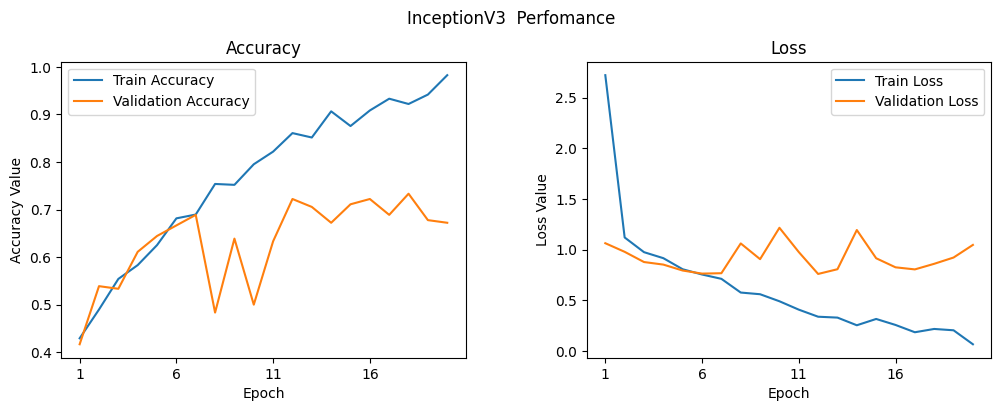

In [ ]:
InceptionV3_trainTime=InceptionV3_stop-InceptionV3_start
InceptionV3_model_accuracy = InceptionV3_history.history['accuracy'][np.argmin(InceptionV3_history.history['loss'])]
InceptionV3_model_score=InceptionV3_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
InceptionV3_Summary = PrettyTable(["InceptionV3"," "])
InceptionV3_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(InceptionV3_model_accuracy*100)])
InceptionV3_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(InceptionV3_model_score[1]*100)])
InceptionV3_Summary.add_row(["Test Loss in %", "{:.2f}".format(InceptionV3_model_score[0]*100)])
InceptionV3_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(InceptionV3_trainTime)])
print(InceptionV3_Summary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('InceptionV3  Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(InceptionV3_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, InceptionV3_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, InceptionV3_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, InceptionV3_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, InceptionV3_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# MobileNet

In [ ]:
#using InceptionV3 trained model
MobileNet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet',
                                        input_shape=INPUT_SHAPE)
MobileNet.trainable = False
# Freeze the layers
for layer in MobileNet.layers:
    layer.trainable = False

base_MobileNet = MobileNet
base_out_MobileNet = base_MobileNet.output
pool_out_MobileNet = tf.keras.layers.Flatten()(base_out_MobileNet)
hidden1_MobileNet = tf.keras.layers.Dense(512, activation='relu')(pool_out_MobileNet)
drop1_MobileNet = tf.keras.layers.Dropout(rate=0.3)(hidden1_MobileNet)
hidden2_MobileNet = tf.keras.layers.Dense(512, activation='relu')(drop1_MobileNet)
drop2_MobileNet = tf.keras.layers.Dropout(rate=0.3)(hidden2_MobileNet)
out_MobileNet = tf.keras.layers.Dense(3, activation='softmax')(drop2_MobileNet)

MobileNet_model = tf.keras.Model(inputs=base_MobileNet.input, outputs=out_MobileNet)
MobileNet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
MobileNet.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [ ]:
MobileNet_start = time.time()
MobileNet_history = MobileNet_model.fit(x=train_imgs_scaled, y=train_labels_1hotenc,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(val_imgs_scaled, val_labels_1hotenc),
                    verbose=1)
MobileNet_stop = time.time()


Epoch 1/20
26/26 [==============================] - 10s 243ms/step - loss: 2.7135 - accuracy: 0.4459 - val_loss: 1.0584 - val_accuracy: 0.5667
Epoch 2/20
26/26 [==============================] - 2s 90ms/step - loss: 0.9395 - accuracy: 0.6061 - val_loss: 0.7736 - val_accuracy: 0.6556
Epoch 3/20
26/26 [==============================] - 2s 90ms/step - loss: 0.7179 - accuracy: 0.7106 - val_loss: 0.9415 - val_accuracy: 0.5778
Epoch 4/20
26/26 [==============================] - 2s 86ms/step - loss: 0.5123 - accuracy: 0.7978 - val_loss: 1.3358 - val_accuracy: 0.5667
Epoch 5/20
26/26 [==============================] - 2s 88ms/step - loss: 0.4302 - accuracy: 0.8318 - val_loss: 0.7371 - val_accuracy: 0.7111
Epoch 6/20
26/26 [==============================] - 3s 99ms/step - loss: 0.2944 - accuracy: 0.8881 - val_loss: 0.9388 - val_accuracy: 0.7333
Epoch 7/20
26/26 [==============================] - 2s 94ms/step - loss: 0.2666 - accuracy: 0.9103 - val_loss: 1.2835 - val_accuracy: 0.6222
Epoch 8/20


## MobileNet Summary

25/25 [==============================] - 2s 52ms/step - loss: 1.1995 - accuracy: 0.7237
+--------------------------------+--------+
|           MobileNet            |        |
+--------------------------------+--------+
|      Model Accuracy in %       | 99.63  |
|       Test Accuracy in %       | 72.37  |
|         Test Loss in %         | 119.95 |
| Time Taken To Train in Seconds | 59.85  |
+--------------------------------+--------+


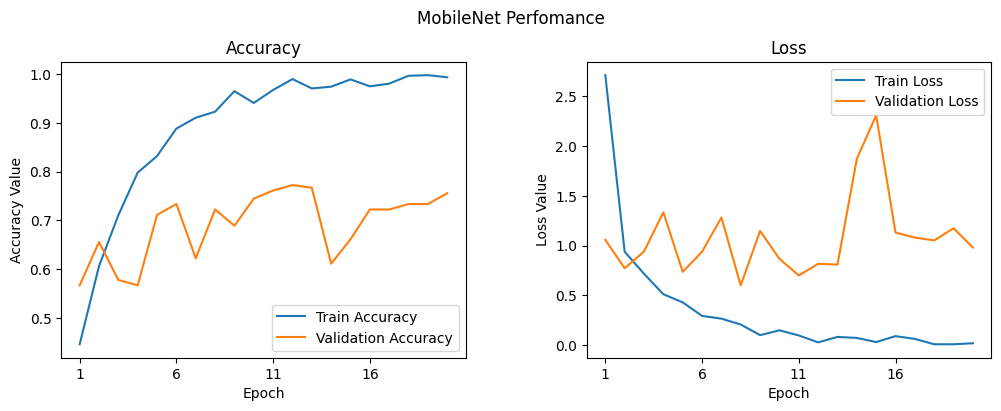

In [ ]:
MobileNet_trainTime=MobileNet_stop-MobileNet_start
MobileNet_model_accuracy = MobileNet_history.history['accuracy'][np.argmin(MobileNet_history.history['loss'])]
MobileNet_model_score=MobileNet_model.evaluate(test_imgs_scaled,test_labels_1hotenc)
MobileNet_Summary = PrettyTable(["MobileNet"," "])
MobileNet_Summary.add_row(["Model Accuracy in %", "{:.2f}".format(MobileNet_model_accuracy*100)])
MobileNet_Summary.add_row(["Test Accuracy in %", "{:.2f}".format(MobileNet_model_score[1]*100)])
MobileNet_Summary.add_row(["Test Loss in %", "{:.2f}".format(MobileNet_model_score[0]*100)])
MobileNet_Summary.add_row(["Time Taken To Train in Seconds", "{:.2f}".format(MobileNet_trainTime)])
print(MobileNet_Summary)

####graph

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet Perfomance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(MobileNet_history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, MobileNet_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, MobileNet_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, MobileNet_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, MobileNet_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Summary

In [ ]:
Summary = PrettyTable(["Model Name", "Model Train Accuracy in %", "Model Test Accuracy in %","Time Taken To Train in Seconds"])
#Summary.add_row(["Vgg16", "{:.2f}".format(vgg16_model_accuracy*100),"{:.2f}".format(vgg16_model_score[1]*100),"{:.2f}".format(vgg16_trainTime)])
Summary.add_row(["Vgg19", "{:.2f}".format(vgg19_model_accuracy*100),"{:.2f}".format(vgg19_model_score[1]*100),"{:.2f}".format(vgg19_trainTime)])
Summary.add_row(["Xception", "{:.2f}".format(Xception_model_accuracy*100),"{:.2f}".format(Xception_model_score[1]*100),"{:.2f}".format(Xception_trainTime)])
Summary.add_row(["ResNet", "{:.2f}".format(ResNet_model_accuracy*100),"{:.2f}".format(ResNet_model_score[1]*100),"{:.2f}".format(ResNet_trainTime)])
Summary.add_row(["InceptionV3", "{:.2f}".format(InceptionV3_model_accuracy*100),"{:.2f}".format(InceptionV3_model_score[1]*100),"{:.2f}".format(InceptionV3_trainTime)])
Summary.add_row(["MobileNet", "{:.2f}".format(MobileNet_model_accuracy*100),"{:.2f}".format(MobileNet_model_score[1]*100),"{:.2f}".format(MobileNet_trainTime)])

print(Summary)
f, ax = plt.subplots(2, 2, figsize=(15, 12))
t = f.suptitle('Summary', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = list(range(1,21))


#ax[0,0].plot(epoch_list, vgg16_history.history['accuracy'], label='vgg16')
ax[0,0].plot(epoch_list, vgg19_history.history['accuracy'], label='vgg19')
ax[0,0].plot(epoch_list, Xception_history.history['accuracy'], label='Xception')
ax[0,0].plot(epoch_list, ResNet_history.history['accuracy'], label='ResNet')
ax[0,0].plot(epoch_list, InceptionV3_history.history['accuracy'], label='InceptionV3')
ax[0,0].plot(epoch_list, MobileNet_history.history['accuracy'], label='MobileNet')
ax[0,0].set_xticks(np.arange(1, max_epoch, 5))
ax[0,0].set_ylabel('Accuracy Value')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_title('Train Accuracy')
l1 = ax[0,0].legend(loc="best")


#ax[0,1].plot(epoch_list, vgg16_history.history['loss'], label='vgg16')
ax[0,1].plot(epoch_list, vgg19_history.history['loss'], label='vgg19')
ax[0,1].plot(epoch_list, Xception_history.history['loss'], label='Xception')
ax[0,1].plot(epoch_list, ResNet_history.history['loss'], label='ResNet')
ax[0,1].plot(epoch_list, InceptionV3_history.history['loss'], label='InceptionV3')
ax[0,1].plot(epoch_list, MobileNet_history.history['loss'], label='MobileNet')
ax[0,1].set_xticks(np.arange(1, max_epoch, 5))
ax[0,1].set_ylabel('Loss Value')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_title('Train Loss')
l2 = ax[0,1].legend(loc="best")

#ax[1,0].plot(epoch_list, vgg16_history.history['val_accuracy'], label='vgg16')
ax[1,0].plot(epoch_list, vgg19_history.history['val_accuracy'], label='vgg19')
ax[1,0].plot(epoch_list, Xception_history.history['val_accuracy'], label='Xception')
ax[1,0].plot(epoch_list, ResNet_history.history['val_accuracy'], label='ResNet')
ax[1,0].plot(epoch_list, InceptionV3_history.history['val_accuracy'], label='InceptionV3')
ax[1,0].plot(epoch_list, MobileNet_history.history['val_accuracy'], label='MobileNet')
ax[1,0].set_xticks(np.arange(1, max_epoch, 5))
ax[1,0].set_ylabel('Accuracy Value')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_title(' Validation Accuracy')
l3 = ax[1,0].legend(loc="best")


#ax[1,1].plot(epoch_list, vgg16_history.history['val_loss'], label='vgg16')
ax[1,1].plot(epoch_list, vgg19_history.history['val_loss'], label='vgg19')
ax[1,1].plot(epoch_list, Xception_history.history['val_loss'], label='Xception')
ax[1,1].plot(epoch_list, ResNet_history.history['val_loss'], label='ResNet')
ax[1,1].plot(epoch_list, InceptionV3_history.history['val_loss'], label='InceptionV3')
ax[1,1].plot(epoch_list, MobileNet_history.history['val_loss'], label='MobileNet')
ax[1,1].set_xticks(np.arange(1, max_epoch, 5))
ax[1,1].set_ylabel('Loss Value')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_title('Validation Loss')
l4 = ax[1,1].legend(loc="best")

# Prediction

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from matplotlib import pyplot
img='/content/input/intel-mobileodt-cervical-cancer-screening/test/test/1.jpg'
data = pyplot.imread(img)
pyplot.imshow(data)
ax = pyplot.gca()
pyplot.show()
ex = ProcessPoolExecutor()

test1_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate([img])]
test1_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in test1_data_inp],
                        [record[1] for record in test1_data_inp],
                        [record[2] for record in test1_data_inp])
test1_data = np.array(list(test1_data_map))
test1_imgs_scaled = test1_data / 255.

#print("######Generate a vgg16 prediction########")
#vgg16_prediction = vgg16_model.predict(test1_imgs_scaled)
#
#if (vgg16_prediction[0][0] >= vgg16_prediction[0][1]) and (vgg16_prediction[0][0] >= vgg16_prediction[0][2]):
#    print("Test image is Classified as Type 1 with {:.2f}% in vgg16".format(vgg16_prediction[0][0]*100))
#elif (vgg16_prediction[0][1] >= vgg16_prediction[0][0]) and (vgg16_prediction[0][1] >= vgg16_prediction[0][2]):
#    print("Test image is Classified as Type 2 with {:.2f}% in vgg16".format(vgg16_prediction[0][1]*100))
#else:
#    print("Test image is Classified as Type 3 with {:.2f}% in vgg16".format(vgg16_prediction[0][2]*100))
#
#print("                                                                 ")
print("######Generate a vgg19 prediction########")
vgg19_prediction = vgg19_model.predict(test1_imgs_scaled)

if (vgg19_prediction[0][0] >= vgg19_prediction[0][1]) and (vgg19_prediction[0][0] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in vgg19".format(vgg19_prediction[0][0]*100))
elif (vgg19_prediction[0][1] >= vgg19_prediction[0][0]) and (vgg19_prediction[0][1] >= vgg19_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in vgg19".format(vgg19_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in vgg19".format(vgg19_prediction[0][2]*100))


print("                                                                 ")
print("######Generate a Xception  prediction########")
Xception_prediction = Xception_model.predict(test1_imgs_scaled)

if (Xception_prediction[0][0] >= Xception_prediction[0][1]) and (Xception_prediction[0][0] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in Xception".format(Xception_prediction[0][0]*100))
elif (Xception_prediction[0][1] >= Xception_prediction[0][0]) and (Xception_prediction[0][1] >= Xception_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in Xception".format(Xception_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in Xception".format(Xception_prediction[0][2]*100))

print("                                                                 ")
print("######Generate a ResNet prediction########")
ResNet_prediction = ResNet_model.predict(test1_imgs_scaled)

if (ResNet_prediction[0][0] >= ResNet_prediction[0][1]) and (ResNet_prediction[0][0] >= ResNet_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in ResNet".format(ResNet_prediction[0][0]*100))
elif (ResNet_prediction[0][1] >= ResNet_prediction[0][0]) and (ResNet_prediction[0][1] >= ResNet_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in ResNet".format(ResNet_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in ResNet".format(ResNet_prediction[0][2]*100))

print("                                                                 ")
print("######Generate a InceptionV3  prediction########")
InceptionV3_prediction = InceptionV3_model.predict(test1_imgs_scaled)

if (InceptionV3_prediction[0][0] >= InceptionV3_prediction[0][1]) and (InceptionV3_prediction[0][0] >= InceptionV3_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in InceptionV3 ".format(InceptionV3_prediction[0][0]*100))
elif (InceptionV3_prediction[0][1] >= vgg19_prediction[0][0]) and (InceptionV3_prediction[0][1] >= InceptionV3_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in InceptionV3".format(InceptionV3_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in InceptionV3".format(InceptionV3_prediction[0][2]*100))


print("                                                                 ")
print("######Generate a MobileNet prediction########")
MobileNet_prediction = MobileNet_model.predict(test1_imgs_scaled)

if (MobileNet_prediction[0][0] >= MobileNet_prediction[0][1]) and (MobileNet_prediction[0][0] >= MobileNet_prediction[0][2]):
    print("Test image is Classified as Type 1 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][0]*100))
elif (MobileNet_prediction[0][1] >= MobileNet_prediction[0][0]) and (MobileNet_prediction[0][1] >= MobileNet_prediction[0][2]):
    print("Test image is Classified as Type 2 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][1]*100))
else:
    print("Test image is Classified as Type 3 with {:.2f}% in MobileNet".format(MobileNet_prediction[0][2]*100))